# Predicting the spread of COVID-19 in Italy
In this notebook I will try to replicate and "*analyze*" the results presented in this [article](https://statisticallearningtheory.wordpress.com/2020/03/02/previsione-della-crescita-esponenziale-dei-covid19-positivi-in-italia-lombardia-veneto-ed-e-romagna/) about the spread of COVID-19 in Italy, using concepts from [regression analysis](https://en.wikipedia.org/wiki/Regression_analysis). 

**Premise:** I have no knowledge in the medical field and this notebook has to be intended as an amateur work. Please, do not take any of the results achieved in this work too seriously.

In the cited article, the growth of the infected population is modeled under the simplified hypothesis that it follows an *exponential growth*. The model class in which we'll seek for a good approximation of the function describing the growth is then:

$$\text{model class: }\left\{y(t)=ce^{rt}\text{, parameter} =(c,r)\right\}$$

where:
- $y(t)$ is the number of infected people at time $t$ (in the article $y=N_{positivi}$);
- $t$ indicates the number of days since a reference date (e.g. Mar 01, 2020);
- unknown parameters $c \in \mathbb{R}^+$ and $r \in \mathbb{R}^+$.

In the *measurement model*, we are used to write $u_i$ and $y_i$ for the *i*-th input and measure respectively, but since, in this case, the input represents the days that have passed since a certain date, I hope no one gets offended if I write the measurement model as:

$$y_t = ce^{rt} + \varepsilon$$

where $\varepsilon$ is a random *error term* independent from $t$.

This is a **non-linear model** because it can't be expressed as a linear combination of its parameters. In general, it is quite difficult to manage non-linear functions in an optimization context, since the function that we want to optimize (the gradient of a certain cost function) can have many local minima and gradient descent techniques are not guaranteed to converge to the global minimum.

Anyway, if we assume that the error is positive and multiplicative (instead of additive), we can take the natural logarithm of both sides of the equation and obtain:

$$\ln(y_t) = \ln(c) + rt + \ln(\varepsilon)$$

that is a **linear model** in the parameters $(\ln(c), r)$.

Let's try to implement linear regression in Python using data taken from the Official Department of Civil Protection: [Dati COVID-19 Italia](https://github.com/pcm-dpc/COVID-19/blob/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# download updated data
!curl https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv -O

In [32]:
dataset = pd.read_csv('dpc-covid19-ita-andamento-nazionale.csv')
start_date = '2020-03-01' # choose start date

y = dataset[dataset['data'] >= start_date].totale_casi
lny = np.log(y)
n = len(y)
t = np.arange(n) # t = [0, 1, ..., n-1]

X = np.array([np.ones(n), t]).T # construct matrix of regressors

# approach 1: solving the normal equations: params = (X'X)^-1 X' lny
# (lnc, r) = np.dot(np.linalg.inv(X.T @ X) @ X.T, lny)

# Trying different approach in order to give more importance to numbers of last days
# Weighted Least Squares: params = (X'WX)^-1 X'W*lny
w = 0.8
W = np.diag(list(map(lambda x: w**(n - x - 1), range(n))))
(lnc, r) = np.dot(np.linalg.inv(X.T @ W @ X) @ X.T @ W, lny)

# approach 2: with the Moore-Penrose pseudoinverse
#(lnc, r) = np.dot(np.linalg.pinv(X), lny)

# approach 3: solving a rectangular linear system in the sense of least squares
#(lnc, r) = np.linalg.lstsq(X, lny, rcond=None)[0]

# approach 4: linear regression with batch gradient descent
#(explained later in the notebook)

c = np.exp(lnc)
print('parameter c is expected to be {:.2f}'.format(c))
print('parameter r is expected to be {:.4f}'.format(r))

parameter c is expected to be 1886.34
parameter r is expected to be 0.1863


## Visualize the results

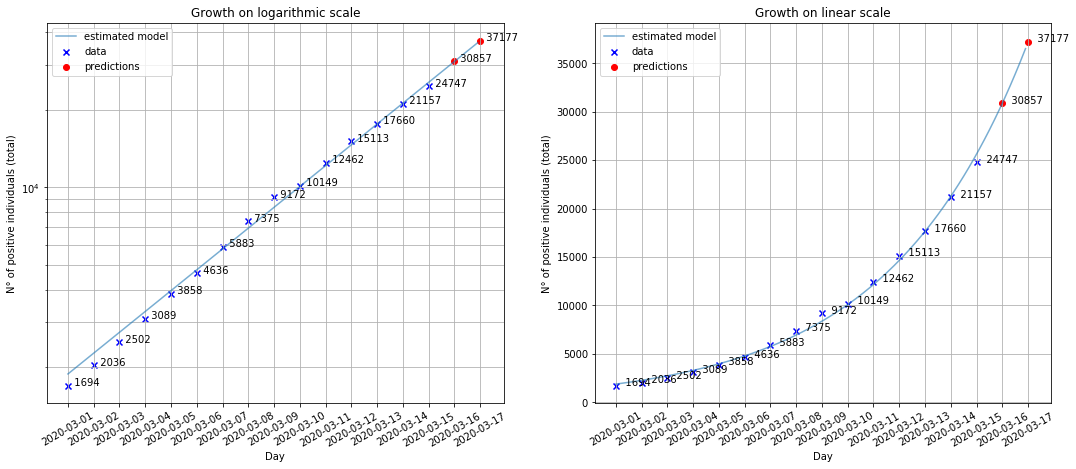

In [34]:
# sample data for plotting purposes
t_start = np.datetime64(start_date) # first day
days = 16 # days to consider since t_start
dates = np.arange(t_start, t_start + days + 1) # list of days from t_start to (t_start + days)
xx = np.arange(0, days, 0.1)
yy = c * np.exp(r*xx)

# predictions for next days
t_pred = np.arange(t[-1] + 1, days + 1)
y_pred = c * np.exp(r*t_pred)

# plot: semilogarithmic scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.scatter(t, y, marker='x', color='b', label='data')
ax1.scatter(t_pred, y_pred, marker='o', color='r', label='predictions')
ax1.semilogy(xx, yy, alpha=0.6, label='estimated model')
ax1.grid(True, which='both')
ax1.set_xticks(range(days+1))
ax1.set_xticklabels(dates)
ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
ax1.set_title('Growth on logarithmic scale')
ax1.set_xlabel('Day')
ax1.set_ylabel('N° of positive individuals (total)')
ax1.legend()
[ax1.annotate('  {:.0f}'.format(y), (t, y)) for (t,y) in zip(np.hstack((t, t_pred)), np.hstack((y, y_pred)))]

# plot: linear scale
ax2.scatter(t, y, marker='x', color='b', label='data')
ax2.scatter(t_pred, y_pred, marker='o', color='r', label='predictions')
ax2.plot(xx, yy, alpha=0.6, label='estimated model')
ax2.grid(True)
ax2.set_xticks(range(days+1))
ax2.set_xticklabels(dates)
ax2.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2.set_xlabel('Day')
ax2.set_ylabel('N° of positive individuals (total)')
ax2.set_title('Growth on linear scale')
ax2.legend()
[ax2.annotate('   {:.0f}'.format(y), (t, y)) for (t,y) in zip(np.hstack((t, t_pred)), np.hstack((y, y_pred)))]
plt.show()

## Considerations I

Predictions are not reliable in first place because of the decision to make tampons only to symptomatic subjects and because the daily capacity of analyzable tempons is approaching saturation.

## Considerations II (WORK IN PROGRESS)
### Exponential growth

An exponential model (a **Malthusian growth model**) is based on the idea that the function describing the growth of the population is proportional to the speed to which it grows, under the assumption that the population is isolated and the resources available are unlimited. Indeed, in continuous time, the exponential model comes as a solution of the Cauchy problem:

$$
\begin{cases}
\frac{\text{d}y}{\text{d}t} = ry(t) \\
y(t_0)=c
\end{cases}
$$

where:
- $r =$ population growth rate
- $c_0 =$ initial population size
- $t_0=0$

This problem admits the solution

$$y(t)=ce^{rt}$$

which is the model we originally assumed for the spread of the virus.

To have a better grasp of it, let's return to discrete time. If we suppose that:

- $y_t$ is the number of cases on a given day
- $E$ is the average number of people someone infected is exposed to each day
- $p$ is the probability of each exposure becoming an infection

then the number of new cases on a given day $\Delta y_t$ is given by

$$\Delta y_t = E\cdot p \cdot y_t$$

where $E\cdot p$ is what we previously called $r$, and so:

$$ y_{t+1} = y_t + \Delta y_t $$
$$ y_{t+1} = y_t + E\cdot p\cdot y_t $$
$$ y_{t+1} = (1 + E\cdot p) \cdot y_t $$
$$y_t = (1 + E\cdot p)^t \cdot y_0$$

As we can observe, the only way for this growth to stop is for the number $E$ or for the number $p$ to decrease, and it is inevitable that this will eventually happen. Even if we assume the most pernicious model, in which, every day, each infected person is exposed to a **random** subset of the whole population, at some point, most of the people they are exposed to will already be infected and can't become new cases. Thus, the probability $p$ of each exposure becoming an infection will have to include a factor to account for the probability that the person to which someone sick is exposed to, isn't already infected. For istance $p$ may be:

$$p = \left(1 - \frac{y_t}{\text{population size}} \right)$$

Including that factor, we'll get what's called a *logistic model*. Note that, in reality, it is not true that infected people can randomly encounter any individual of the entire population, indeed people are clustered in local communities with a lower probability to encounter people from different clusters. Note also that saturating the whole population is not the only thing that can cause the growth rate to slow down, indeed if people stop gathering and travelling, then $E$ will decrease, and if people start to adopt precautions, such as washing their hands, mantaining distance from each other, etc. then also $p$ can decrease.


In conclusion, modelling the spread of the virus as an exponential curve is too simplistic because the fundamental **assumption** of the Malthusian growth is that the **resources are unlimited**.

### Logistic growth

In nature, populations may grow exponentially for some period, but they will ultimately be limited by resource availability. For these reasons, we should adopt a more reasonable model, namely the **Verhulst logistic model**.
In logistic growth, a population's per capita growth rate gets smaller and smaller as population size approaches a maximum imposed by limited resources in the environment, known as the **carrying capacity** $K$.

$$\frac{\text{d}y}{\text{d}t} = ry\left(1-\frac{y}{K}\right)$$

a solution to this equation is:

$$y(t)=\frac{K}{1+cKe^{-rt}}$$

where $c = \frac{1}{y(0)} - \frac{1}{K}$ depends on the initial condition $y(0)$. This function usually goes under the name of [*logistic curve*](https://en.wikipedia.org/wiki/Logistic_function) (or logistic sigmoid function).

A logistic function has the following shape (consider the solution with $y(0)<K$):

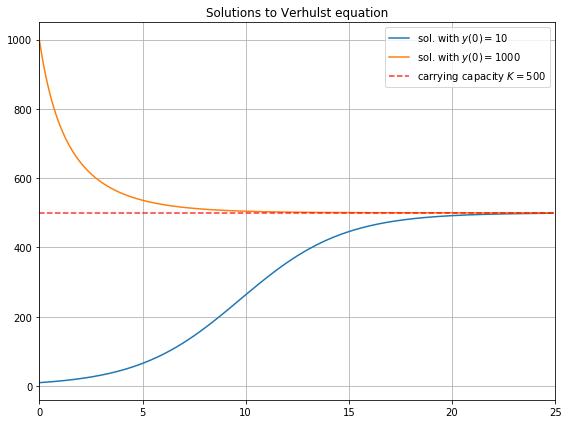

In [0]:
def logistic(t, K, r, y0):
  return K / (1.0 + (1.0/y0 - 1.0/K) * K * np.exp(-r * t))

K = 500
r = 0.4

t = np.arange(0, 25, 0.1)
y_t = logistic(t, K, r, y0=10)
plt.subplots(figsize=(8,6))
plt.plot(t, y_t, label=r'sol. with $y(0)={10}$')
y_t = logistic(t, K, r, y0=1000)
plt.plot(t, y_t, label=r'sol. with $y(0)={1000}$')
plt.plot([0,25],[K, K], c='r', linestyle='dashed', alpha=0.8, label='carrying capacity $K={}$'.format(K))
plt.title('Solutions to Verhulst equation')
plt.xlim(0, 25)
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Predicting a logistic growth

If we take a look to the recoveries trend from the virus in China (see [this image](https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_outbreak#/media/File:2020_coronavirus_patients_in_China.svg)), we can observe a similar behavior to the logistic function, and that's why, a model like this can be more reasonable than an exponential growth in the long run.

Now it comes the challenging part: fitting a non-linear function is not trivial at all. The new model class becomes

$$\text{model class: }\left\{y(t)=\frac{K}{1+cKe^{-rt}}\text{, parameter} =(c,r,K)\right\}$$

Observe that the most interesting parameters are $r$ (which describes the growth rate) and $K$ (which is the carrying capacity, i.e. the total number of infected that there will be).

```
Work in progress on this topic
```

## EXTRA: Implementing Linear Regression with gradient descent from scratch
When the number of data is very large (millions of entries), solving the normal equations can take lot of time, because it requires to invert an $(n\times n)$ matrix (where $n$ is the number of data points) and inverting a matrix has a computational complexity of $O(n^3)$.

For this reason, a common strategy adopted to minimize the cost function is *steepest descent* of its gradient function.

After a brief, non-rigorous explanation of how [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) works, you will find a simple implementation of linear regression using standard *batch gradient descent*.

The simplest implementation of gradient descent consists into repeating, until a termination condition is met, the following update rule for each parameter:

$$\theta_j := \theta_j - \eta \frac{\partial}{\partial \theta_j}{J(\theta)}$$


where:
- $\theta_j$ is the *j*-th parameter (or weight)
- $\eta$ is the step (or learning rate)
- $J(\theta)$ is a cost function to be minimized

In linear regression, the cost function is usually the sum of squared errors (residuals):

$$J(\theta)=\frac{1}{2}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)}^2$$

where the estimate $\hat{y}_i$ is given by the scalar product between the *i*-th regressor (in our case $\varphi_i= [1, x_i]^T$) and the parameter vector (in our case $\theta=[\theta_1, \theta_2]^T=[c,r]^T$).

$$\hat{y}_i=\varphi_i^T \theta$$

By computing its partial derivative with respect to $\theta_j$ we obtain:

$$\frac{\partial}{\partial \theta_j}{J(\theta)}=-\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)}x_i^{(j)}$$

Note: the superscript $(j)$ in $x_i^{(j)}$ indicates the *j*-th element of the *i*-th regressors $\varphi_i$.

Then, at each step of the gradient descent algorithm, each of the coefficients is updated according to the following rule:

$$\theta_j := \theta_j + \eta \sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)}x_i^{(j)}$$

In [39]:
class LinearRegressionGD(object):
  """Simple linear regression using batch gradient descent"""

  def __init__(self, eta=0.01, n_iter=200):
    self.eta = eta
    self.n_iter = n_iter

  def fit(self, X, y):
    """
    X is the matrix containing the regressors (features).
    Its first column must be a column of ones
    """
    self.coef_ = np.zeros(X.shape[1]) # parameters (weights) vector
    self.cost_ = []

    # Gradient descent
    for i in range(self.n_iter):
      output = self.predict(X)
      errors = (y - output)
      self.coef_ += self.eta * X.T.dot(errors)
      cost = (errors**2).sum() / 2.0
      self.cost_.append(cost)
    return self

  def predict(self, X):
    return np.dot(X, self.coef_)


# Approach 4: Solve the exponential growth problem with linear regression + gradient descent
lr = LinearRegressionGD(eta=0.001, n_iter=1500)
lr.fit(X, lny) # train the model
(lnc, r) = lr.coef_ # extract estimated coefficients
c = np.exp(lnc)
print('parameter c is expected to be {:.2f}'.format(c))
print('parameter r is expected to be {:.4f}'.format(r))


parameter c is expected to be 1725.24
parameter r is expected to be 0.1962
